# Evaluating 2015-2018 Model on 2019 data

In [1]:
import matplotlib
import seaborn
matplotlib.rcParams.update({'font.size': 22})

## Overall RMSE
The RMSE (to 3 decimal places) is 0.200, so worse than the 0.198 we get when we train and evaluate on subsets of 2015 data.

In [2]:
%%bigquery
SELECT  
  SQRT(SUM(
      (CAST(ontime AS FLOAT64) - predicted_ontime.scores[OFFSET(0)])*
      (CAST(ontime AS FLOAT64) - predicted_ontime.scores[OFFSET(0)])
      )/COUNT(*)) AS rmse
FROM dsongcp.ch10_automl_evaluated

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.01rows/s]


,rmse
0,0.199848


## Confusion matrix

Let's find the fraction of true on-time flights at some threshold:

In [3]:
%%bigquery
SELECT 
  *, 
  num_pred_ontime / num_ontime AS frac_1_as_1,
  num_pred_late   / num_ontime AS frac_1_as_0,
  num_pred_ontime / num_late AS frac_0_as_1,
  num_pred_late   / num_late AS frac_0_as_0
FROM (
    SELECT  
      0.7 AS thresh,
      SUM(IF(CAST(ontime AS FLOAT64) > 0.5, 1, 0)) AS num_ontime,
      SUM(IF(CAST(ontime AS FLOAT64) <= 0.5, 1, 0)) AS num_late,
      SUM(IF(predicted_ontime.scores[OFFSET(0)] > 0.7, 1, 0)) AS num_pred_ontime,
      SUM(IF(predicted_ontime.scores[OFFSET(0)] <= 0.7, 1, 0)) AS num_pred_late,
    FROM dsongcp.ch10_automl_evaluated
)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.09rows/s]


,thresh,num_ontime,num_late,num_pred_ontime,num_pred_late,frac_1_as_1,frac_1_as_0,frac_0_as_1,frac_0_as_0
0,0.7,5878979,1389253,5818115,1450117,0.989647,0.246661,4.187945,1.043811


In [4]:
%%bigquery
WITH counts AS (
    SELECT
      thresh,  
      COUNTIF(CAST(ontime AS FLOAT64) > 0.5 AND predicted_ontime.scores[OFFSET(0)] > thresh) AS num_1_as_1,
      COUNTIF(CAST(ontime AS FLOAT64) > 0.5 AND predicted_ontime.scores[OFFSET(0)] <= thresh) AS num_1_as_0,
      COUNTIF(CAST(ontime AS FLOAT64) <= 0.5 AND predicted_ontime.scores[OFFSET(0)] > thresh) AS num_0_as_1,
      COUNTIF(CAST(ontime AS FLOAT64) <= 0.5 AND predicted_ontime.scores[OFFSET(0)] <= thresh) AS num_0_as_0
    FROM UNNEST([0.5, 0.7, 0.8]) AS thresh, dsongcp.ch10_automl_evaluated
    GROUP BY thresh
)

SELECT 
  *, 
  ROUND(num_1_as_1 / (num_1_as_1 + num_1_as_0), 2) AS frac_1_as_1,
  ROUND(num_1_as_0 / (num_1_as_1 + num_1_as_0), 2) AS frac_1_as_0,
  ROUND(num_0_as_1 / (num_0_as_1 + num_0_as_0), 2) AS frac_0_as_1,
  ROUND(num_0_as_0 / (num_0_as_1 + num_0_as_0), 2) AS frac_0_as_0
FROM counts
ORDER BY thresh ASC

Downloading: 100%|██████████| 3/3 [00:00<00:00,  3.29rows/s]


,thresh,num_1_as_1,num_1_as_0,num_0_as_1,num_0_as_0,frac_1_as_1,frac_1_as_0,frac_0_as_1,frac_0_as_0
0,0.5,5763136,115843,258138,1131115,0.98,0.02,0.19,0.81
1,0.7,5633570,245409,184545,1204708,0.96,0.04,0.13,0.87
2,0.8,5498807,380172,146200,1243053,0.94,0.06,0.11,0.89


In [5]:
%%bigquery df
WITH counts AS (
    SELECT
      thresh,  
      COUNTIF(CAST(ontime AS FLOAT64) > 0.5 AND predicted_ontime.scores[OFFSET(0)] > thresh) AS num_1_as_1,
      COUNTIF(CAST(ontime AS FLOAT64) > 0.5 AND predicted_ontime.scores[OFFSET(0)] <= thresh) AS num_1_as_0,
      COUNTIF(CAST(ontime AS FLOAT64) <= 0.5 AND predicted_ontime.scores[OFFSET(0)] > thresh) AS num_0_as_1,
      COUNTIF(CAST(ontime AS FLOAT64) <= 0.5 AND predicted_ontime.scores[OFFSET(0)] <= thresh) AS num_0_as_0
    FROM UNNEST(GENERATE_ARRAY(0.0, 1.0, 0.01)) AS thresh, dsongcp.ch10_automl_evaluated
    GROUP BY thresh
)

SELECT 
  *, 
  ROUND(num_1_as_1 / (num_1_as_1 + num_1_as_0), 2) AS frac_1_as_1,
  ROUND(num_1_as_0 / (num_1_as_1 + num_1_as_0), 2) AS frac_1_as_0,
  ROUND(num_0_as_1 / (num_0_as_1 + num_0_as_0), 2) AS frac_0_as_1,
  ROUND(num_0_as_0 / (num_0_as_1 + num_0_as_0), 2) AS frac_0_as_0
FROM counts
ORDER BY thresh ASC

Downloading: 100%|██████████| 100/100 [00:00<00:00, 101.40rows/s]


In [6]:
df.head()

,thresh,num_1_as_1,num_1_as_0,num_0_as_1,num_0_as_0,frac_1_as_1,frac_1_as_0,frac_0_as_1,frac_0_as_0
0,0.00,5878979,0,1375064,14189,1.0,0.0,0.99,0.01
1,0.01,5878150,829,669299,719954,1.0,0.0,0.48,0.52
2,0.02,5877151,1828,619923,769330,1.0,0.0,0.45,0.55
3,0.03,5876074,2905,588231,801022,1.0,0.0,0.42,0.58
4,0.04,5874898,4081,564113,825140,1.0,0.0,0.41,0.59


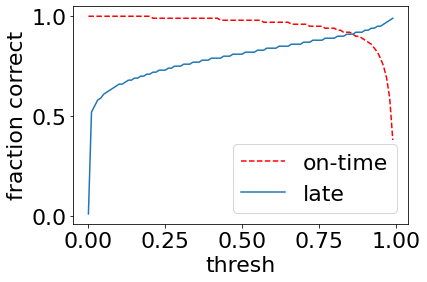

In [7]:
ax = df.plot(x='thresh', y='frac_1_as_1', label='on-time', ylabel='fraction correct', style='r--');
df.plot(x='thresh', y='frac_0_as_0', label='late', ax=ax);

## Impact of different variables

Let's see how the model behaves with respect to specific feature values

In [8]:
%%bigquery df
SELECT
  ROUND(predicted_ontime.scores[OFFSET(0)], 2) AS prob_ontime,
  AVG(CAST(dep_delay AS FLOAT64)) AS dep_delay,
  STDDEV(CAST(dep_delay AS FLOAT64)) AS std_dep_delay,
  AVG(CAST(taxi_out AS FLOAT64)) AS taxi_out,
  STDDEV(CAST(taxi_out AS FLOAT64)) AS std_taxi_out
FROM dsongcp.ch10_automl_evaluated
GROUP BY prob_ontime
ORDER BY prob_ontime ASC

Downloading: 100%|██████████| 101/101 [00:00<00:00, 108.12rows/s]


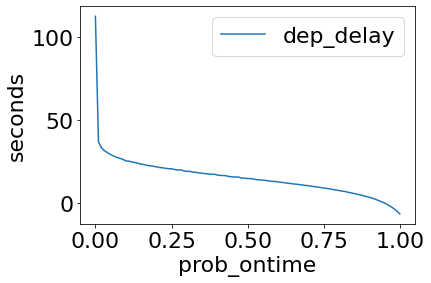

In [9]:
df.plot(x='prob_ontime', y='dep_delay', ylabel='seconds');

In [10]:
%%bigquery df2
SELECT
  ROUND(CAST(dep_delay AS FLOAT64), 0) AS dep_delay,
  AVG(predicted_ontime.scores[OFFSET(0)]) AS prob_ontime,
FROM dsongcp.ch10_automl_evaluated
GROUP BY dep_delay
ORDER BY dep_delay ASC

Downloading: 100%|██████████| 1592/1592 [00:01<00:00, 1363.40rows/s]


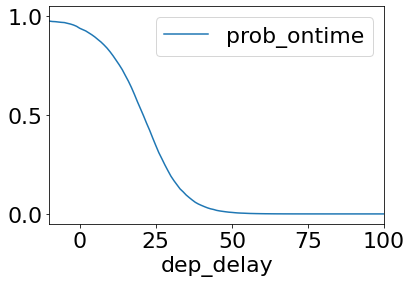

In [11]:
df2.plot(x='dep_delay', y='prob_ontime', xlim=[-10,100]);

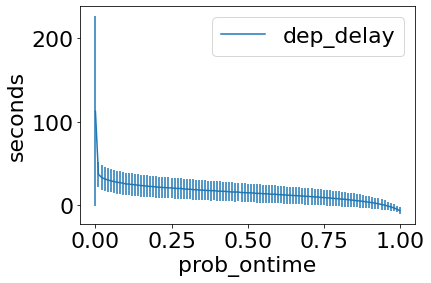

In [12]:
df.plot(x='prob_ontime', y='dep_delay', yerr='std_dep_delay', ylabel='seconds');

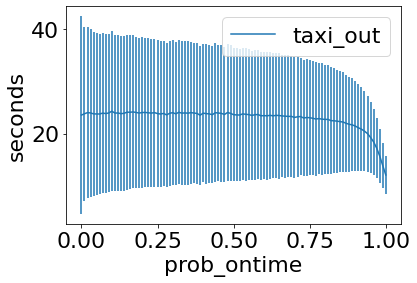

In [13]:
df.plot(x='prob_ontime', y='taxi_out', yerr='std_taxi_out', ylabel='seconds');

## Analyzing mistakes

Looking at correct vs. wrong predictions

In [14]:
%%bigquery df
WITH preds AS (
  SELECT
    CAST(ontime AS FLOAT64) AS ontime,
    ROUND(predicted_ontime.scores[OFFSET(0)], 2) AS prob_ontime,
    CAST(dep_delay AS FLOAT64) AS var,
  FROM dsongcp.ch10_automl_evaluated
)

SELECT 
  prob_ontime, 
  AVG(IF((ontime > 0.5 and prob_ontime <= 0.5) or (ontime <= 0.5 and prob_ontime > 0.5), var, NULL)) AS wrong,
  AVG(IF((ontime > 0.5 and prob_ontime > 0.5) or (ontime <= 0.5 and prob_ontime <= 0.5), var, NULL)) AS correct
FROM preds
GROUP BY prob_ontime
ORDER BY prob_ontime

Downloading: 100%|██████████| 101/101 [00:00<00:00, 107.47rows/s]


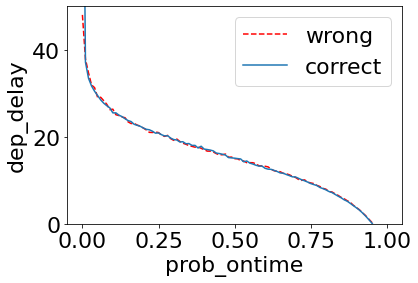

In [15]:
ax = df.plot(x='prob_ontime', y='wrong', ylim=(0, 50), ylabel='dep_delay', style='r--');
df.plot(x='prob_ontime', y='correct', ax=ax, ylim=(0, 50));

In [16]:
%%bigquery df
WITH preds AS (
  SELECT
    CAST(ontime AS FLOAT64) AS ontime,
    ROUND(predicted_ontime.scores[OFFSET(0)], 2) AS prob_ontime,
    CAST(taxi_out AS FLOAT64) AS var,
  FROM dsongcp.ch10_automl_evaluated
)

SELECT 
  prob_ontime, 
  AVG(IF((ontime > 0.5 and prob_ontime <= 0.5) or (ontime <= 0.5 and prob_ontime > 0.5), var, NULL)) AS wrong,
  AVG(IF((ontime > 0.5 and prob_ontime > 0.5) or (ontime <= 0.5 and prob_ontime <= 0.5), var, NULL)) AS correct
FROM preds
GROUP BY prob_ontime
ORDER BY prob_ontime

Downloading: 100%|██████████| 101/101 [00:01<00:00, 83.01rows/s] 


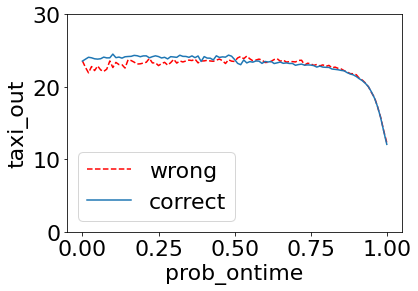

In [17]:
ax = df.plot(x='prob_ontime', y='wrong', ylim=(0, 30), ylabel='taxi_out', style='r--');
df.plot(x='prob_ontime', y='correct', ax=ax, ylim=(0, 30));

## Categorical Features


In [18]:
%%bigquery df2
SELECT
  ROUND(CAST(dep_delay AS FLOAT64), 0) AS dep_delay,
  AVG(IF(origin='JFK', predicted_ontime.scores[OFFSET(0)], NULL)) AS JFK,
  AVG(IF(origin='SEA', predicted_ontime.scores[OFFSET(0)], NULL)) AS SEA,
FROM dsongcp.ch10_automl_evaluated
GROUP BY dep_delay
ORDER BY dep_delay ASC

Downloading: 100%|██████████| 1592/1592 [00:00<00:00, 1670.67rows/s]


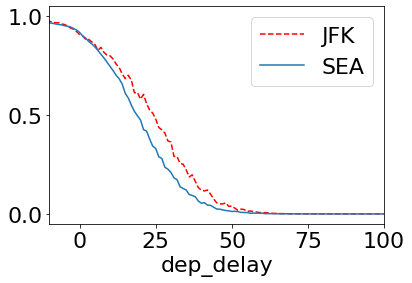

In [19]:
ax = df2.plot(x='dep_delay', y='JFK', xlim=[-10,100], style='r--');
df2.plot(x='dep_delay', y='SEA', xlim=[-10,100], ax=ax);

In [20]:
%%bigquery df2
SELECT
  carrier,
  ROUND(CAST(dep_delay AS FLOAT64), 0) AS dep_delay,
  AVG(predicted_ontime.scores[OFFSET(0)]) AS prob_ontime
FROM dsongcp.ch10_automl_evaluated
GROUP BY carrier, dep_delay
ORDER BY carrier ASC, dep_delay ASC

Downloading: 100%|██████████| 13667/13667 [00:01<00:00, 12650.01rows/s]


In [21]:
df = df2.copy()
df.head()

,carrier,dep_delay,prob_ontime
0,9E,-35.0,0.999952
1,9E,-34.0,0.943798
2,9E,-33.0,0.999634
3,9E,-32.0,0.999904
4,9E,-31.0,0.998244


In [22]:
df = df2.set_index('dep_delay')
df.head()

,carrier,prob_ontime
dep_delay,,
-35.0,9E,0.999952
-34.0,9E,0.943798
-33.0,9E,0.999634
-32.0,9E,0.999904
-31.0,9E,0.998244


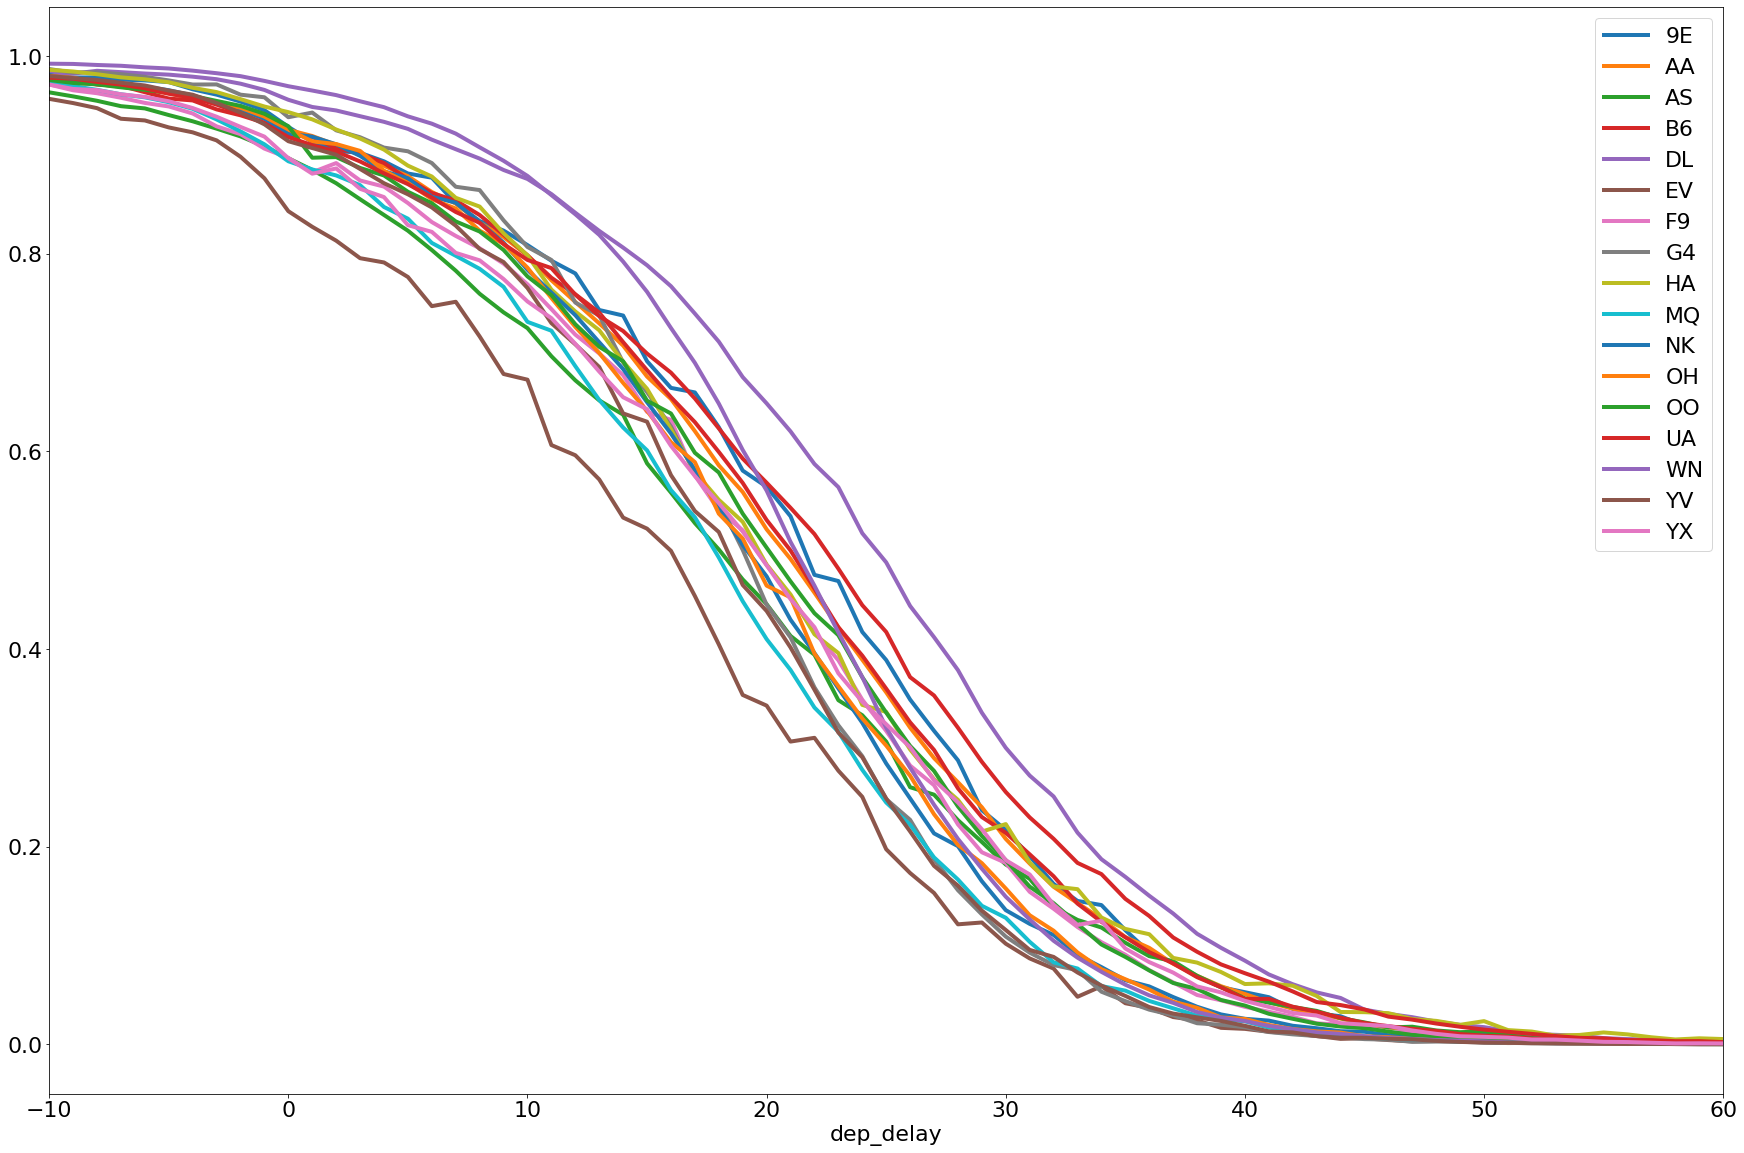

In [23]:
df.groupby('carrier')['prob_ontime'].plot(xlim=[-10,60], legend=True, figsize=(30,20), lw=4);

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License